In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from autogluon.tabular import TabularPredictor

import warnings
import pickle
import shutil
import os

warnings.filterwarnings("ignore")

In [15]:
class configs:

    train_path = "playground-series-s5e6/train.csv"
    test_path = "playground-series-s5e6/test.csv"
    original_path = "playground-series-s5e6/Fertilizer Prediction.csv"
    sample_sub_path = "playground-series-s5e6/sample_submission.csv"

    target = "Fertilizer Name"
    n_folds = 5
    seed = 42
    time_limit = 3600 * 5

## 1. Data Loading

In [3]:
train = pd.read_csv(configs.train_path, index_col="id")
test = pd.read_csv(configs.test_path, index_col="id")
original = pd.read_csv(configs.original_path)

label_encoder = LabelEncoder()
train[configs.target] = label_encoder.fit_transform(train[configs.target])
original[configs.target] = label_encoder.transform(original[configs.target])

## 2. Define Folds

In [4]:
skf = StratifiedKFold(n_splits=configs.n_folds, random_state=configs.seed, shuffle=True)
split = skf.split(train, train[configs.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, "fold"] = i

## 3. Predictor Fitting

In [5]:
%%writefile custom_metric.py

from autogluon.core.metrics import make_scorer
import numpy as np

def map3(y_true, y_pred_probs):
    y_true = [[x] for x in y_true]
    y_pred_probs = np.argsort(y_pred_probs, axis=1)[:, -3:][:, ::-1].tolist()
    
    def ap3(y_true, y_pred_probs):
        y_pred_probs = y_pred_probs[:3]

        score = 0.0
        num_hits = 0.0

        for i,p in enumerate(y_pred_probs):
            if p in y_true and p not in y_pred_probs[:i]:
                num_hits += 1.0
                score += num_hits / (i+1.0)

        if not y_true:
            return 0.0

        return score
    
    return np.mean([ap3(a,p) for a,p in zip(y_true, y_pred_probs)])

ag_map3 = make_scorer(
    name='map3',
    score_func=map3,
    optimum=1,
    needs_proba=True,
    greater_is_better=True
)

Writing custom_metric.py


In [6]:
from custom_metric import ag_map3

predictor = TabularPredictor(
    path="/logs",
    problem_type="multiclass",
    eval_metric=ag_map3,
    label=configs.target,
    groups="fold",
    verbosity=2
)

In [7]:
predictor.fit_pseudolabel(
    pseudo_data=original,
    train_data=train,
    time_limit=configs.time_limit,
    presets="best_quality",
    excluded_model_types = ["KNN", "RF", "CAT"]
)

Predictor not fit prior to pseudolabeling. Fitting now...
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       5.20 GB / 15.92 GB (32.6%)
Disk Space Avail:   54.98 GB / 930.67 GB (5.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is use

(_ray_fit pid=35980) [1000]	valid_set's multi_logloss: 1.92406	valid_set's map3: 0.322582
(_ray_fit pid=35980) [2000]	valid_set's multi_logloss: 1.92332	valid_set's map3: 0.324832 [repeated 5x across cluster]
(_ray_fit pid=25700) [2000]	valid_set's multi_logloss: 1.924	valid_set's map3: 0.324166 [repeated 4x across cluster]
(_ray_fit pid=35980) [3000]	valid_set's multi_logloss: 1.92456	valid_set's map3: 0.325481
(_ray_fit pid=39552) [3000]	valid_set's multi_logloss: 1.92547	valid_set's map3: 0.325095


(_ray_fit pid=39552) 	Ran out of time, early stopping on iteration 3575. Best iteration is:
(_ray_fit pid=39552) 	[3548]	valid_set's multi_logloss: 1.92644	valid_set's map3: 0.325806
(_dystack pid=39592) 	0.3256	 = Validation score   (map3)
(_dystack pid=39592) 	2132.38s	 = Training   runtime
(_dystack pid=39592) 	2582.96s	 = Validation runtime
(_ray_fit pid=25700) 	Ran out of time, early stopping on iteration 3567. Best iteration is: [repeated 4x across cluster]
(_ray_fit pid=25700) 	[3376]	valid_set's multi_logloss: 1.92622	valid_set's map3: 0.325189 [repeated 4x across cluster]
(_dystack pid=39592) Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.00s of the 1487.17s of remaining time.
(_dystack pid=39592) 	Ensemble Weights: {'LightGBMXT_BAG_L1': 1.0}
(_dystack pid=39592) 	0.3256	 = Validation score   (map3)
(_dystack pid=39592) 	61.56s	 = Training   runtime
(_dystack pid=39592) 	1.07s	 = Validation runtime
(_dystack pid=39592) Excluded models: ['RF', 'KNN', 'CAT']

In [8]:
predictor.leaderboard(silent=True).style.background_gradient(subset=["score_val"], cmap="RdYlGn")

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3_PSEUDO,0.346245,map3,6294.551581,14095.687715,2.103848,597.969321,3,True,37
1,WeightedEnsemble_L2_PSEUDO,0.346011,map3,6247.889488,10476.145519,1.546692,203.231431,2,True,24
2,LightGBMXT_BAG_L2_PSEUDO,0.345913,map3,6255.919227,10861.684671,3.624621,167.407164,2,True,26
3,LightGBM_r96_BAG_L2_PSEUDO,0.345843,map3,6269.143745,11225.929325,16.849139,531.651818,2,True,34
4,LightGBM_r131_BAG_L2_PSEUDO,0.345725,map3,6264.091568,11113.219504,11.796962,418.941997,2,True,32
5,LightGBM_BAG_L2_PSEUDO,0.345676,map3,6255.878217,10866.472129,3.583611,172.194622,2,True,27
6,XGBoost_BAG_L2_PSEUDO,0.345489,map3,6255.560833,10823.399379,3.266226,129.121873,2,True,28
7,LightGBMLarge_BAG_L2_PSEUDO,0.345053,map3,6257.088689,10911.876885,4.794083,217.599379,2,True,30
8,LightGBM_BAG_L1_PSEUDO,0.344178,map3,3299.098496,4273.178785,3299.098496,4273.178785,1,True,21
9,NeuralNetTorch_BAG_L2_PSEUDO,0.343924,map3,6255.988513,11112.379964,3.693907,418.102458,2,True,29


In [9]:
def get_ensemble_weights(predictor):
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
    return ensemble_weights

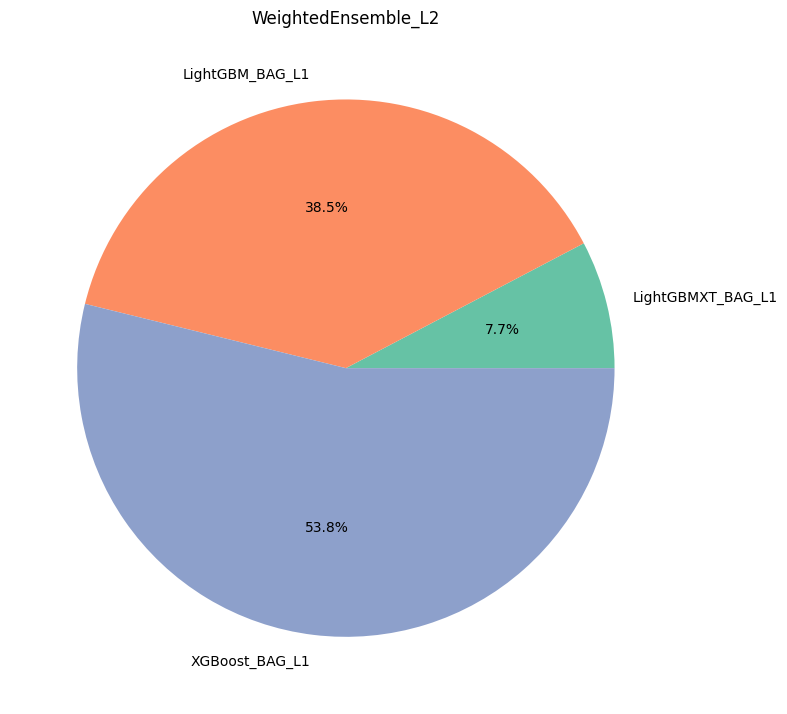

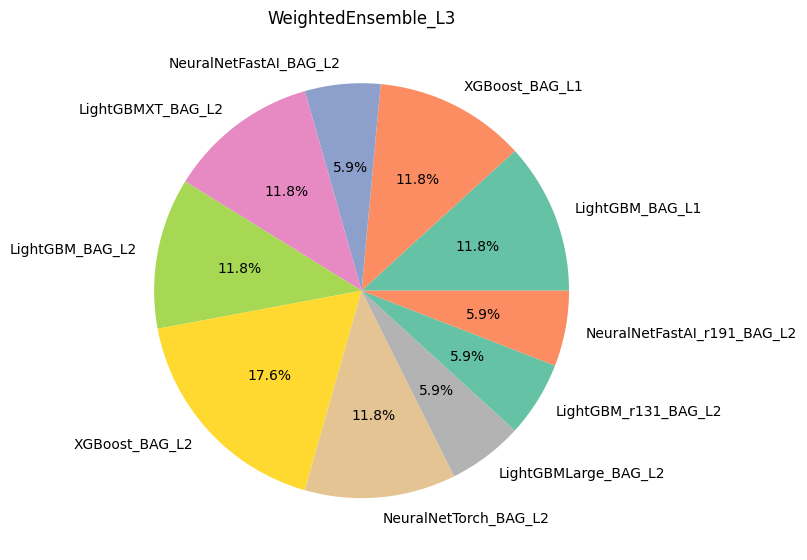

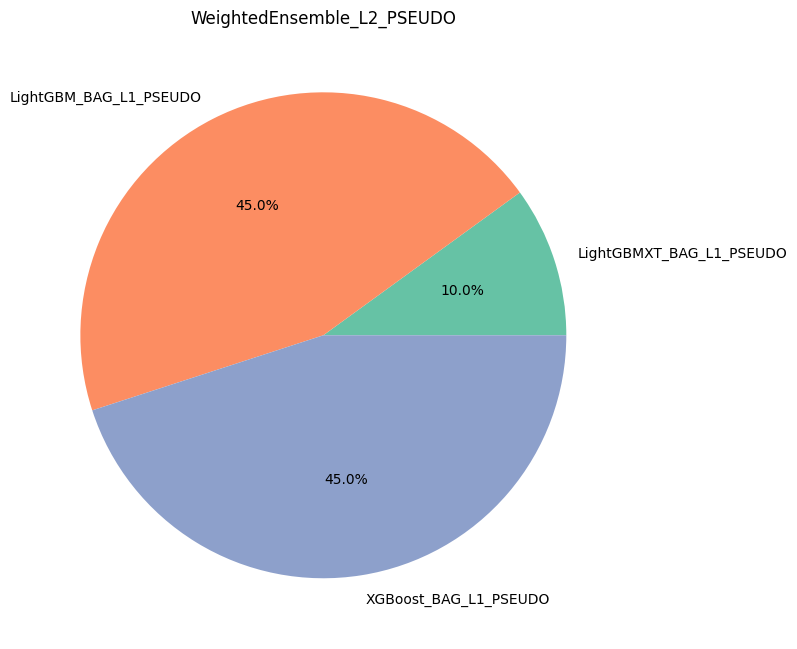

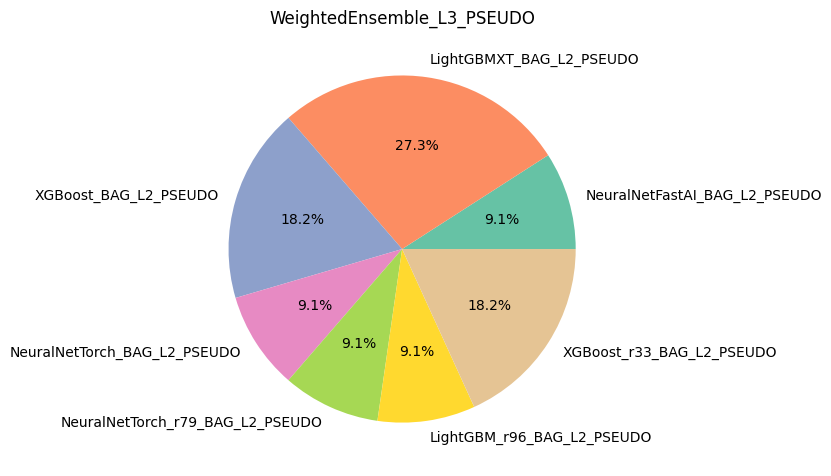

In [10]:
ensemble_weights = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(8, 8))
    plt.pie(value.values(), labels=value.keys(), autopct="%1.1f%%", colors=sns.color_palette("Set2", len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

In [11]:
def save_pred_probs(pred_probs, cv_score, name, type, is_ensemble):
    base_path = "oof_pred_probs" if type == "oof" else "test_pred_probs"
    base_path = "." if is_ensemble else base_path
    with open(f"{base_path}/{name}_{type}_pred_probs_{cv_score:.6f}.pkl", "wb") as f:
        pickle.dump(pred_probs, f)

def save_submission(test_pred_probs, score):
    final_predictions = []
    for i in np.argsort(test_pred_probs, axis=1)[:, -3:][:, ::-1]:
        prediction = label_encoder.inverse_transform(i)
        final_predictions.append(" ".join(prediction))
        
    sub = pd.read_csv(configs.sample_sub_path)
    sub[configs.target] = final_predictions
    sub.to_csv(f"sub_autogluon_{score:.6f}.csv", index=False)
    
os.makedirs("oof_pred_probs", exist_ok=True)
os.makedirs("test_pred_probs", exist_ok=True)

In [12]:
oof_pred_probs = {}
test_pred_probs = {}

In [13]:
def map3(y_true, y_pred_probs):
    y_true = [[x] for x in y_true]
    y_pred_probs = np.argsort(y_pred_probs, axis=1)[:, -3:][:, ::-1].tolist()
    
    def ap3(y_true, y_pred_probs):
        y_pred_probs = y_pred_probs[:3]

        score = 0.0
        num_hits = 0.0

        for i,p in enumerate(y_pred_probs):
            if p in y_true and p not in y_pred_probs[:i]:
                num_hits += 1.0
                score += num_hits / (i+1.0)

        if not y_true:
            return 0.0

        return score
    
    return np.mean([ap3(a,p) for a,p in zip(y_true, y_pred_probs)])

In [16]:
best_model = predictor.model_best
test_pred_probs = predictor.predict_proba_multi(test)
for model in predictor.model_names():
    model_oof_pred_probs = predictor.predict_proba_oof(model).values
    model_test_pred_probs = test_pred_probs[model].values
    
    cv_score = map3(train[configs.target], model_oof_pred_probs)
    if model != best_model:
        save_pred_probs(model_oof_pred_probs, cv_score, model, "oof", False)
        save_pred_probs(model_test_pred_probs, cv_score, model, "test", False)
    else:
        save_pred_probs(model_oof_pred_probs, cv_score, model, "oof", True)
        save_pred_probs(model_test_pred_probs, cv_score, model, "test", True)
        save_submission(model_test_pred_probs, cv_score)
        
    oof_pred_probs[model] = model_oof_pred_probs
    test_pred_probs[model] = model_test_pred_probs

In [17]:
scores = {}
split = StratifiedKFold(n_splits=configs.n_folds, random_state=configs.seed, shuffle=True).split(train, train[configs.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = map3(train.loc[val_index, configs.target], oof_pred_probs[model][val_index])
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

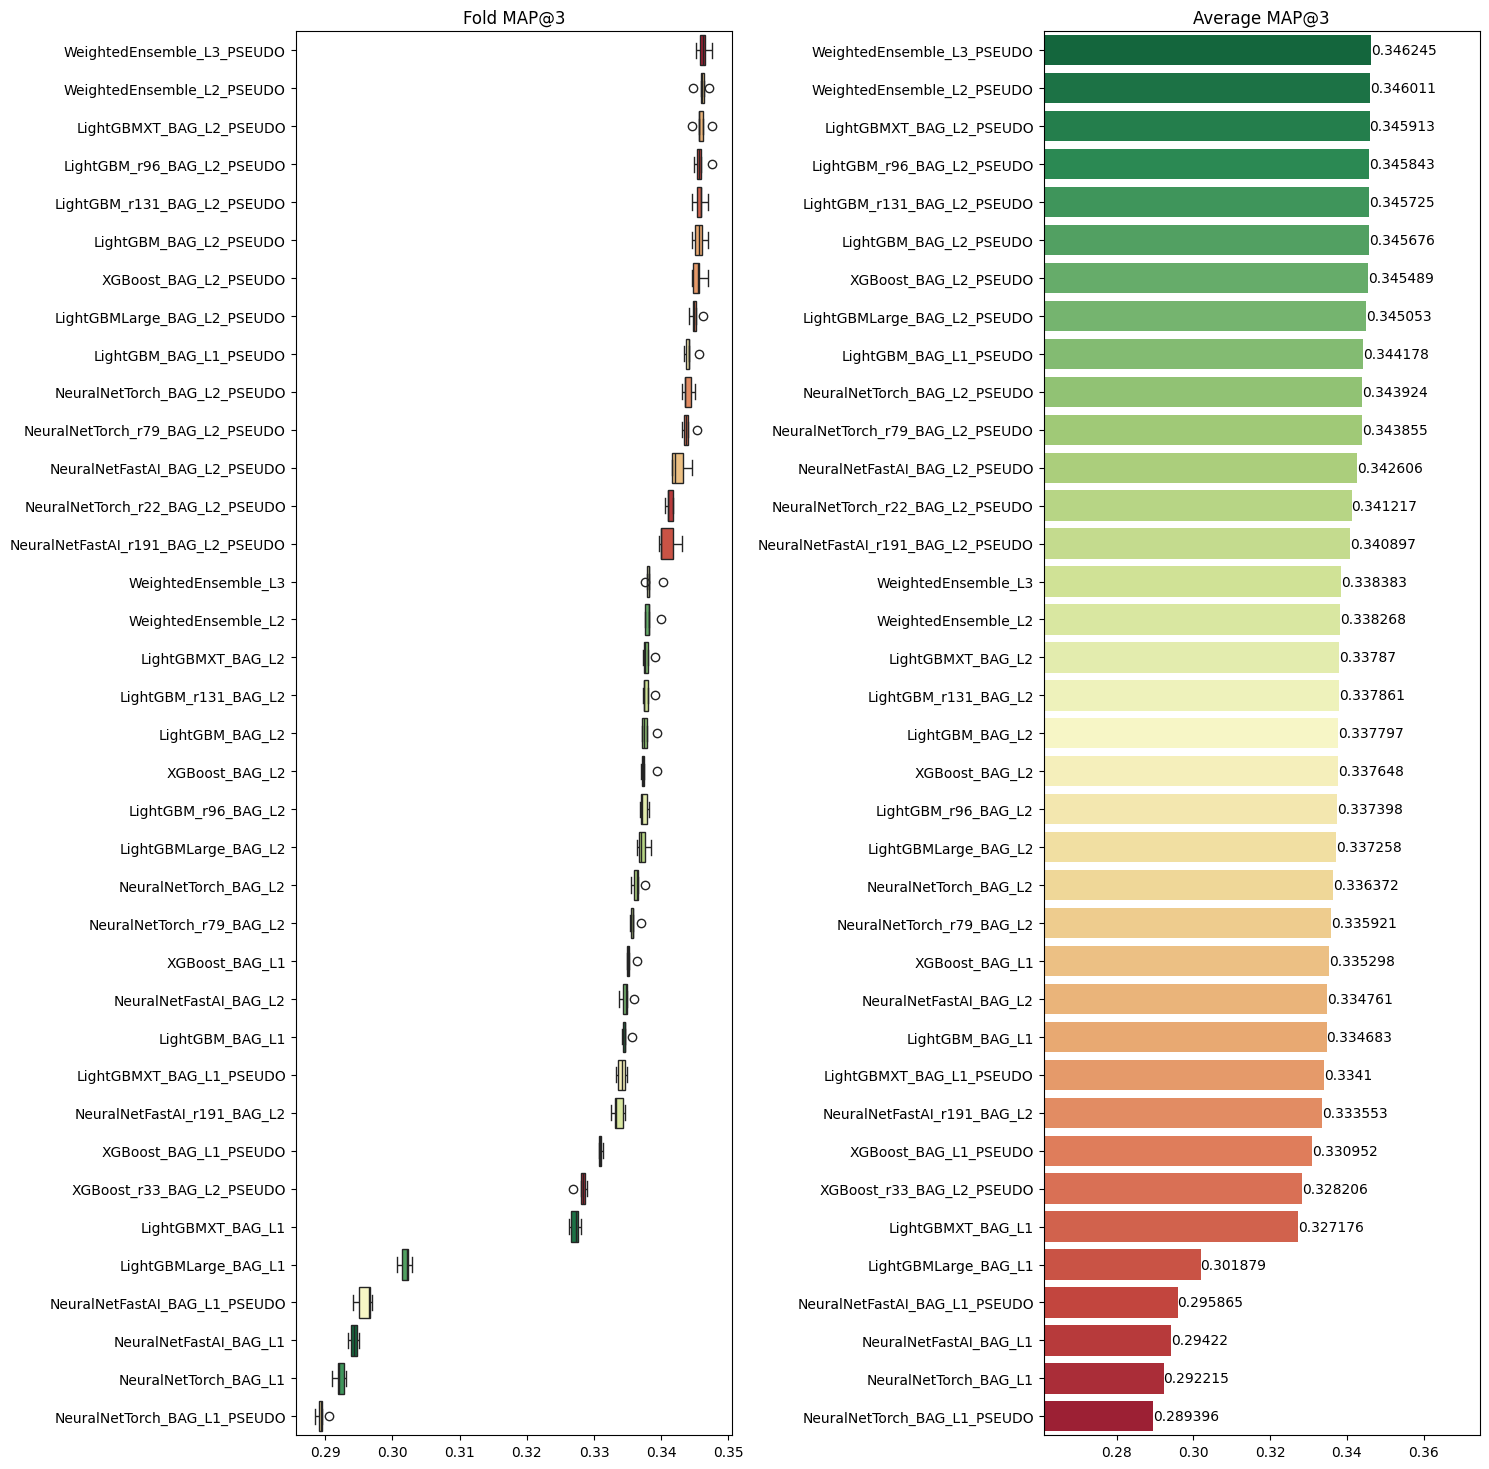

In [18]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", palette="RdYlGn_r")
axs[0].set_title("Fold MAP@3")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette="RdYlGn_r")
axs[1].set_title("Average MAP@3")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()
